# Ages
So, that got away from me!  Ages needs a whole notebook to itself to play and look at the data and options :)

## Thoughts
- Read somewhere that .5's are estimated ages and .2 (or divisor) are partial years where age is below (perhaps 5)???
- Does age AND class have any bearing on survival by class?
- Are ages less likely to have been recorded for women?  Not polite to ask a lady her age...
- Would machine learning be suitable to 'fill' the age?
- Does age have to be exact? 12 year old vs 19 yr old and 42 vs 49
- Number of siblings - can this be used to estimate
- Likewise, is chivalry dead?  Did Jack really give his life for Rose?  Is this usual behaviour?
- Could fare NaN's be crew?  Therefore working age?  Should they be removed to get rid of outliers?
- Women and children first? That'll surely bias things???

## Setup

In [60]:
# source: https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced
# importing the stuff
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# overriding the defaults for pandas: display.max_rows
pd.set_option("display.max_rows", None, "display.max_columns", None)

# loading in the data
test_data = pd.read_csv ('../data/raw/test.csv')
train_data = pd.read_csv("../data/raw/train.csv")

# combining the datasets, this maybe stupid, maybe genius....
# combined=train_data.append(test_data)  # depricated, switching to pd.concat
combined = pd.concat([train_data, test_data])   # Wow, that was easy!

## analysing the data
print('TRAINING Data\nMissing values Percentage: \n\n', round (train_data.isnull().sum().sort_values(ascending=False)/len(combined)*100,1))

TRAINING Data
Missing values Percentage: 

 Cabin          52.5
Age            13.5
Embarked        0.2
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
dtype: float64


In [61]:
print("Average ages by sex and class:\n",train_data.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).round(1))

print("\n\nAverage ages by sex and survival:\n",train_data.groupby(['Sex', 'Survived'])['Age'].agg(['mean', 'median']).round(1))

print ("\n\nAverage age of passenger is", round(train_data['Age'].mean()))


Average ages by sex and class:
                mean  median
Sex    Pclass              
female 1       34.6    35.0
       2       28.7    28.0
       3       21.8    21.5
male   1       41.3    40.0
       2       30.7    30.0
       3       26.5    25.0


Average ages by sex and survival:
                  mean  median
Sex    Survived              
female 0         25.0    24.5
       1         28.8    28.0
male   0         31.6    29.0
       1         27.3    28.0


Average age of passenger is 30


## Creating some new series

In [62]:
# source: https://www.kaggle.com/code/nicapotato/titanic-feature-engineering/notebook

# size of the family
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

# travelling alone?
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1

# additional Source- https://www.kaggle.com/ash316/eda-to-prediction-dietanic via nicapotato (above)
train_data['Title']=0


## TODO: We can infer some kind of class from titles...
# extracting the Salutations
train_data['Title']=train_data.Name.str.extract('([A-Za-z]+)\.') 
train_data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr


In [63]:
# How much of a difference does travelling with parents make to age to Miss passengers?

print ("Avg age of 'Miss' Title", round(train_data[train_data.Title=="Miss"]['Age'].mean()))
print ("Avg age of 'Miss' Title travelling without Parents", round(train_data[(train_data.Title=="Miss") & (train_data.Parch==0)]['Age'].mean()))
print ("Avg age of 'Miss' Title travelling with Parents", round(train_data[(train_data.Title=="Miss") & (train_data.Parch!=0)]['Age'].mean()), '\n')

Avg age of 'Miss' Title 22
Avg age of 'Miss' Title travelling without Parents 28
Avg age of 'Miss' Title travelling with Parents 12 



ooooh!  BIG variance there...

In [64]:
print('Average age of traveller with parent/child', '\n', train_data[(train_data.Title=="Miss") & (train_data.Parch!=0)].groupby('Pclass')['Age'].mean().round())
print('\n','Average age of traveller with NO Parent/Child', '\n',train_data[(train_data.Title=="Miss") & (train_data.Parch==0)].groupby('Pclass')['Age'].mean().round())

Average age of traveller with parent/child 
 Pclass
1    21.0
2    11.0
3     7.0
Name: Age, dtype: float64

 Average age of traveller with NO Parent/Child 
 Pclass
1    34.0
2    30.0
3    22.0
Name: Age, dtype: float64


In [65]:
train_data.Age[train_data.Title=="Mr"].mean()


32.73960880195599

In [66]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,1,1,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,1,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,4,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,1,Mr
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,1,1,Mr


In [67]:
# TODO: These will need tweaking when Title summarisation is amended

train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mr'),'Age'] = train_data.Age[train_data.Title == "Mr"].mean()
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mrs'),'Age'] = train_data.Age[train_data.Title == "Mrs"].mean()
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Master'),'Age'] = train_data.Age[train_data.Title == "Master"].mean()
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Miss'),'Age'] = train_data.Age[train_data.Title == "Miss"].mean()
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Other'),'Age'] = train_data.Age[train_data.Title == "Other"].mean()
train_data = train_data.drop('Name', axis=1)

In [68]:
print('TRAINING Data\nMissing values Percentage: \n\n', round (train_data.isnull().sum().sort_values(ascending=False)/len(combined)*100,1))

# age should now have no missing data

TRAINING Data
Missing values Percentage: 

 Cabin          52.5
Embarked        0.2
PassengerId     0.0
Survived        0.0
Pclass          0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
FamilySize      0.0
IsAlone         0.0
Title           0.0
dtype: float64


In [102]:
# Establishing our bins values and names
bin_labels = ['youngling', 'toddler', 'child', 'teen', 'young_adult', 'adult', 'olderadult', 'elder']
bin_values = [-1, 3, 12, 16, 19, 28, 42, 60, 80]

bin_details = "\n".join("{} {}".format(x,y) for x,y in zip(bin_labels, bin_values))

print(bin_details)

youngling -1
toddler 3
child 12
teen 16
young_adult 19
adult 28
olderadult 42
elder 60


In [103]:
# Applying "Age" binning with Pandas cut
age_bins = pd.cut(train_data['Age'], bins = bin_values, labels = bin_labels)
df_age_bins = pd.DataFrame(age_bins)

In [104]:
# Viewing the distribution of age bins
df_age_bins['Age'].value_counts()


adult          360
young_adult    234
olderadult     107
teen            64
toddler         43
child           31
youngling       30
elder           22
Name: Age, dtype: int64

<AxesSubplot:>

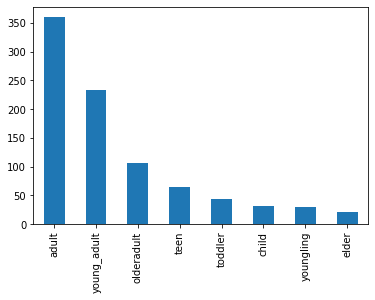

In [105]:
plotdata = df_age_bins['Age'].value_counts()
plotdata.plot(kind="bar")

In [106]:
df_age_bins.head()

,Age
0,young_adult
1,adult
2,young_adult
3,adult
4,adult


In [107]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr


In [108]:
train_data['Age_cat'] = df_age_bins

In [109]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,Age_cat
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,young_adult
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,adult
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,young_adult
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,adult
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,adult


In [ ]:
# TODO: OneHotEncode the Age_cat